In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitsui-commodity-prediction-challenge/target_pairs.csv
/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv
/kaggle/input/mitsui-commodity-prediction-challenge/train.csv
/kaggle/input/mitsui-commodity-prediction-challenge/test.csv
/kaggle/input/mitsui-commodity-prediction-challenge/lagged_test_labels/test_labels_lag_1.csv
/kaggle/input/mitsui-commodity-prediction-challenge/lagged_test_labels/test_labels_lag_4.csv
/kaggle/input/mitsui-commodity-prediction-challenge/lagged_test_labels/test_labels_lag_3.csv
/kaggle/input/mitsui-commodity-prediction-challenge/lagged_test_labels/test_labels_lag_2.csv
/kaggle/input/mitsui-commodity-prediction-challenge/kaggle_evaluation/mitsui_inference_server.py
/kaggle/input/mitsui-commodity-prediction-challenge/kaggle_evaluation/mitsui_gateway.py
/kaggle/input/mitsui-commodity-prediction-challenge/kaggle_evaluation/__init__.py
/kaggle/input/mitsui-commodity-prediction-challenge/kaggle_evaluation/core/templates.py
/kaggle/inpu

In [ ]:
import os
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings("ignore")

# Set precision for memory efficiency
tf.keras.backend.set_floatx('float32')
np.set_printoptions(suppress=True, precision=4)

# Configuration
CONFIG = {
    'window_sizes': [5, 10, 30],
    'lag_periods': [1, 2, 3],
    'pca_components': 200,
    'batch_size': 256,
    'learning_rate': 0.001,
    'epochs': 100,
    'patience': 10,
    'model_units': [512, 256, 128],
    'missing_value_threshold': 0.10  # Drop columns with >10% missing values
}

# Load Data

In [ ]:
# Detect Kaggle environment
IS_KAGGLE = os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None
if IS_KAGGLE:
    import kaggle_evaluation.mitsui_inference_server
    DATA_PATH        = '/kaggle/input/mitsui-commodity-prediction-challenge/'
    MODEL_INPUT_DIR  = '/kaggle/input/model4-suke/' 
    MODEL_OUTPUT_DIR = '/kaggle/working/model'
else:
    DATA_PATH        = './dataset'
    MODEL_INPUT_DIR  = './model/'
    MODEL_OUTPUT_DIR = './model'
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

train = pl.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train_labels = pl.read_csv(os.path.join(DATA_PATH, 'train_labels.csv'))
target_pairs = pl.read_csv(os.path.join(DATA_PATH, 'target_pairs.csv'))
test = pl.read_csv(os.path.join(DATA_PATH, 'test.csv'))

# Perform Exploratory Data Ananlysis

In [ ]:
# Basic data information
print(f"Train shape: {train.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Target pairs shape: {target_pairs.shape}")

Train shape: (1961, 558)
Train labels shape: (1961, 425)
Target pairs shape: (424, 3)


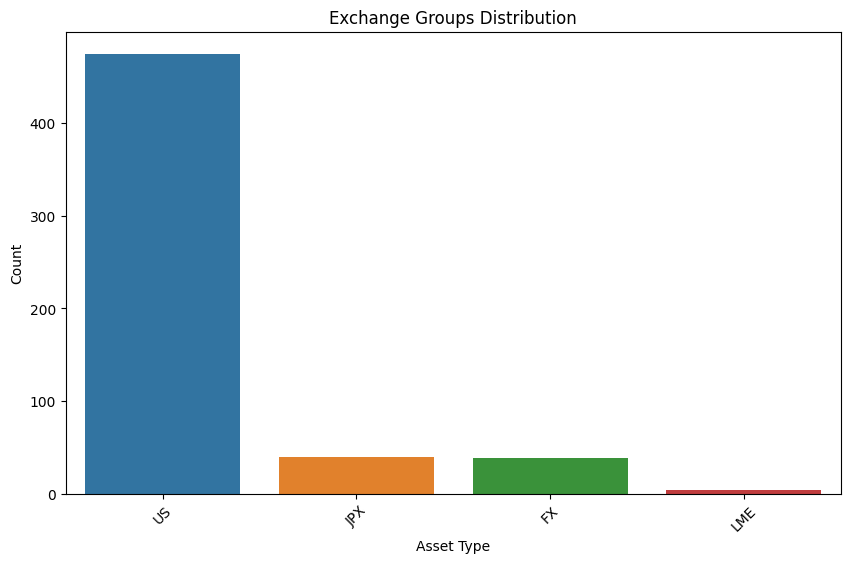

In [ ]:
# Exchange groups distribution
asset_cols = [col for col in train.columns if col != 'date_id']
asset_types = [col.split('_')[0] for col in asset_cols]
asset_type_counts = pd.Series(asset_types).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=asset_type_counts.index, y=asset_type_counts.values)
plt.title('Exchange Groups Distribution')
plt.xlabel('Asset Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

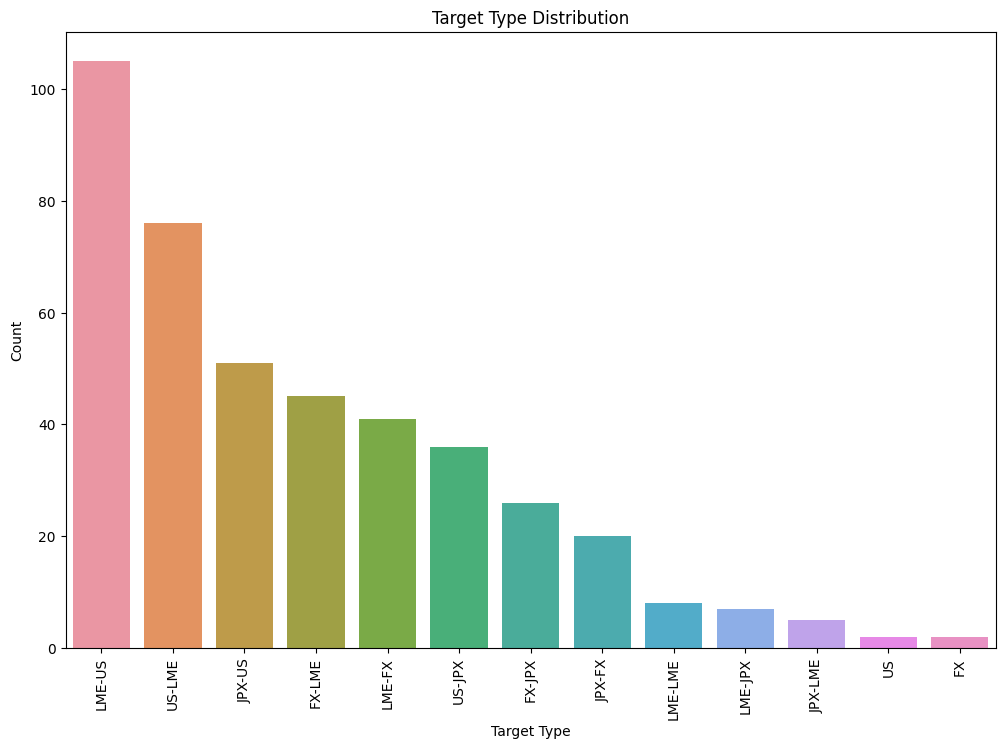

In [ ]:
# Target pairs analysis
target_pairs_df = target_pairs.to_pandas()
target_types = []
for _, row in target_pairs_df.iterrows():
    pair = row['pair']
    if '-' in pair:
        asset1, asset2 = [x.strip() for x in pair.split('-')]
        target_types.append(f"{asset1.split('_')[0]}-{asset2.split('_')[0]}")
    else:
        target_types.append(pair.split('_')[0])

target_type_counts = pd.Series(target_types).value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=target_type_counts.index, y=target_type_counts.values)
plt.title('Target Type Distribution')
plt.xlabel('Target Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

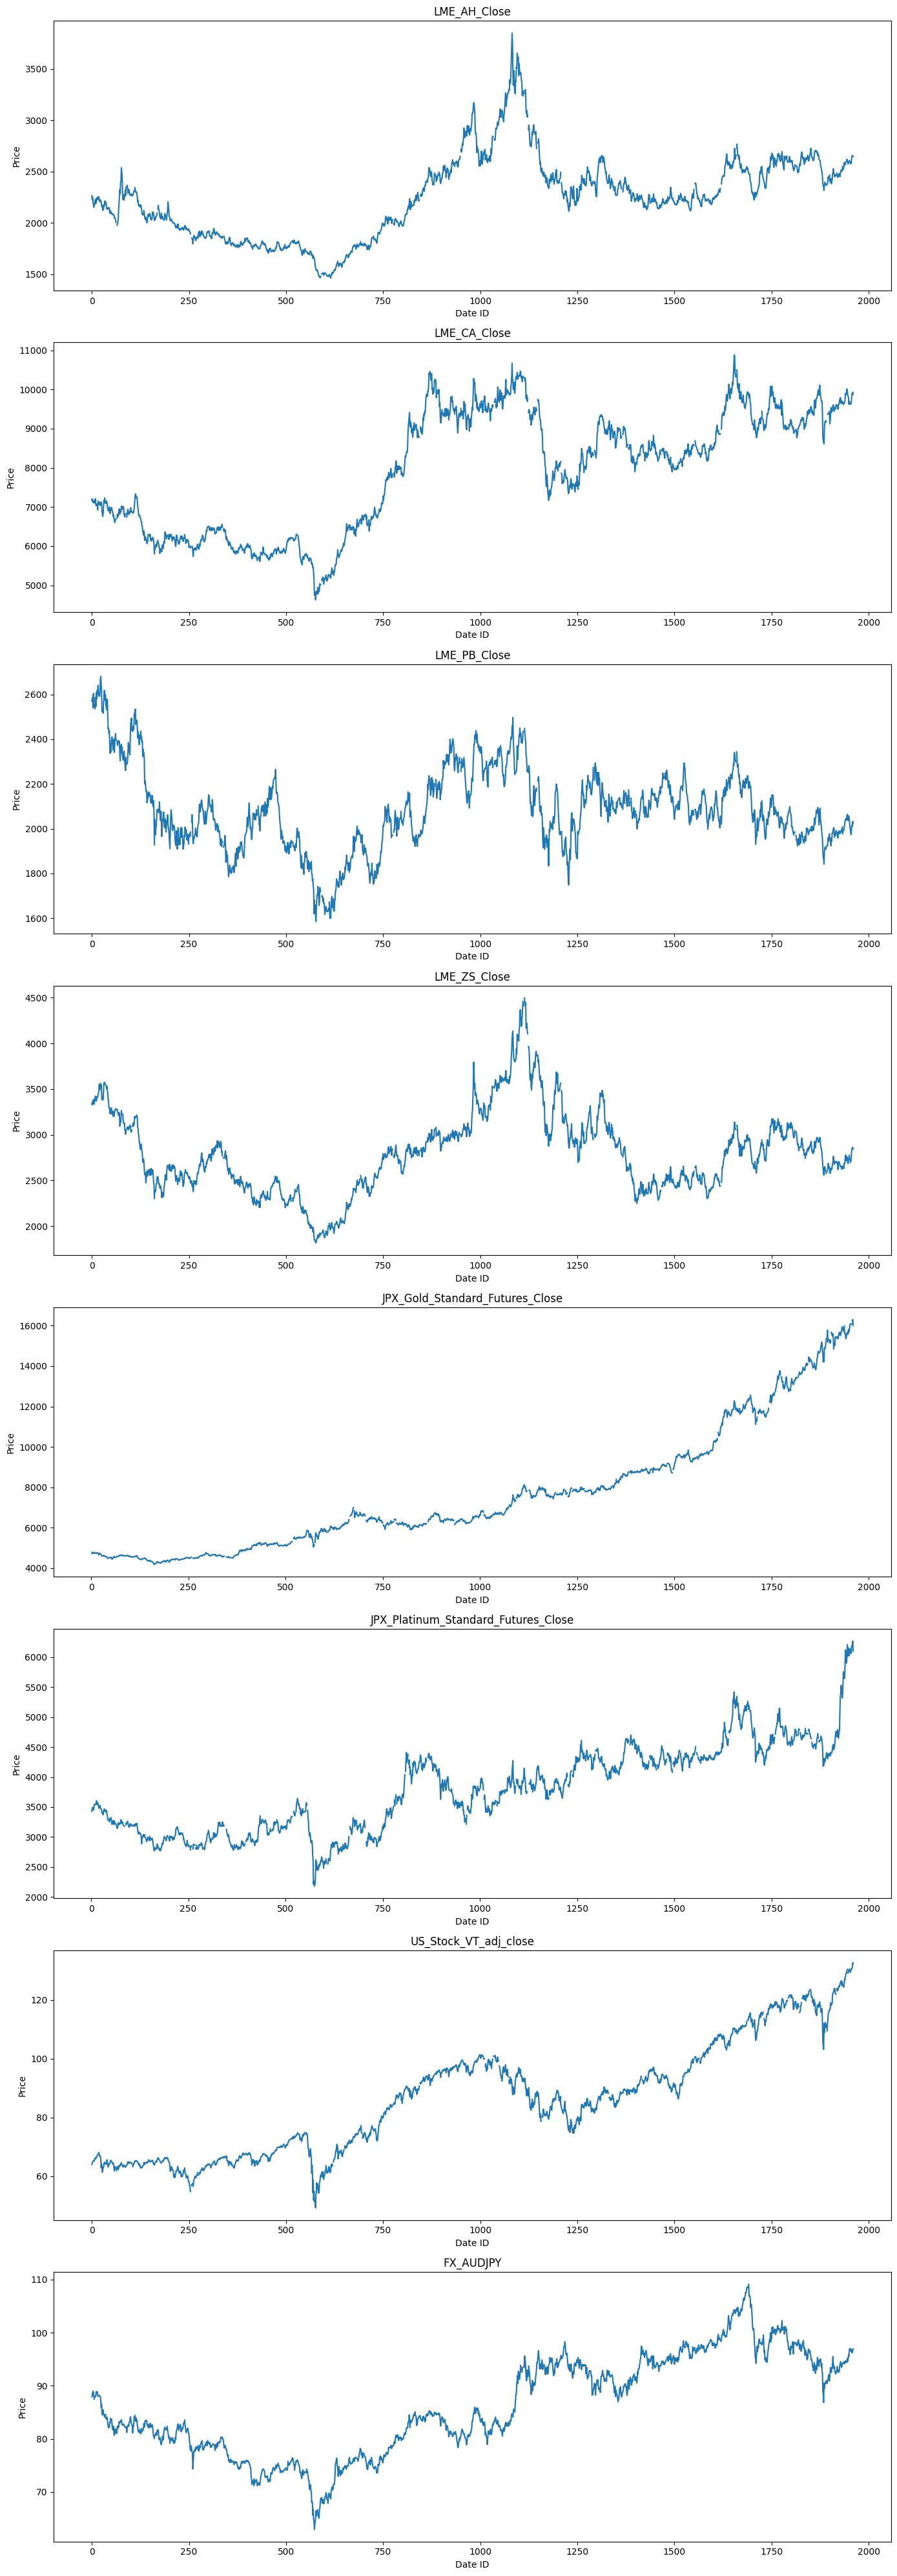

In [ ]:

# Time series visualization for some of the assets
key_assets = ['LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close', 
              'JPX_Gold_Standard_Futures_Close', 'JPX_Platinum_Standard_Futures_Close',
              'US_Stock_VT_adj_close', 'FX_AUDJPY']

# Convert to pandas for plotting
train_pandas = train.to_pandas()
plt.figure(figsize=(14, 40))
for i, asset in enumerate(key_assets):
    plt.subplot(8, 1, i+1)
    plt.plot(train_pandas['date_id'], train_pandas[asset])
    plt.title(asset)
    plt.xlabel('Date ID')
    plt.ylabel('Price')
    # plt.legend()
plt.tight_layout()
plt.show()

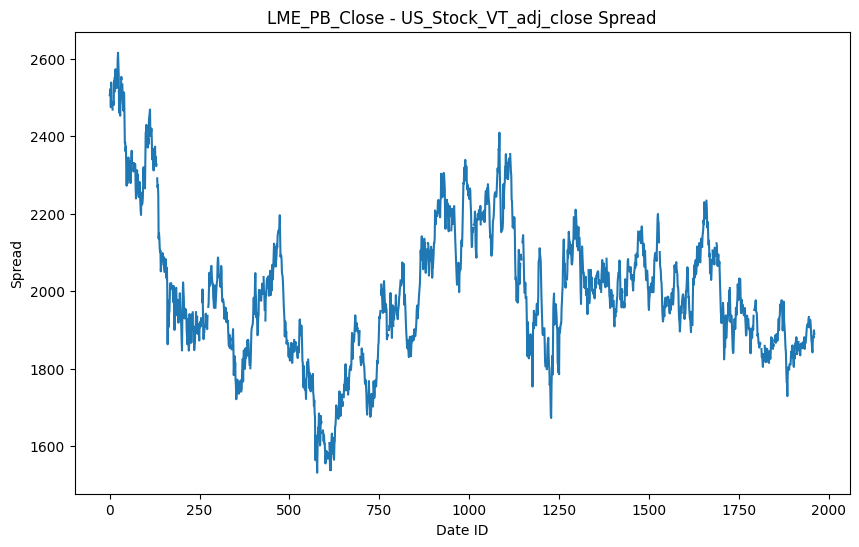

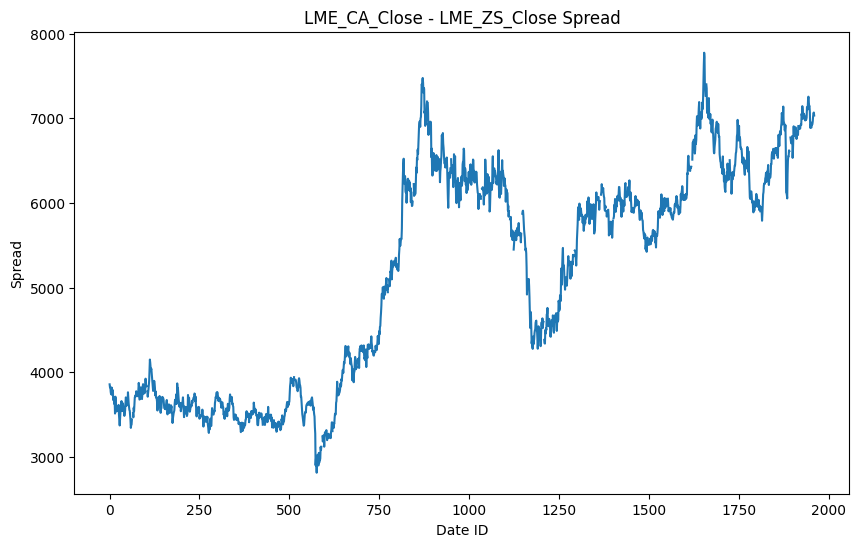

In [ ]:
# Spread visualization for a few target pairs
target_pairs_df = target_pairs.to_pandas()
for i in range(3):
    pair = target_pairs_df.iloc[i]['pair']
    if '-' in pair:
        asset1, asset2 = [x.strip() for x in pair.split('-')]
        spread = train_pandas[asset1] - train_pandas[asset2]
        plt.figure(figsize=(10, 6))
        plt.plot(train_pandas['date_id'], spread)
        plt.title(f"{asset1} - {asset2} Spread")
        plt.xlabel('Date ID')
        plt.ylabel('Spread')
        plt.show()

### Configuration Setting

In [ ]:
# More Configuration
TRAIN_RandomForest = True
TRAIN_LightGBM = False
TRAIN_LGBM_Multiple = True
TRAIN_CatBoost = False
DO_CV = False    
CV_SPLITS = 3
SEED = 42

sns.set_theme(style="darkgrid")

In [ ]:
if 'date_id' in train.columns:
    train_df     = train.sort('date_id')
if 'date_id' in train_labels.columns:
    train_labels = train_labels.sort('date_id')

EXCLUDE_COLS   = {'date_id', 'row_id', 'is_scored'}
COMMON_COLUMNS = [c for c in train_df.columns if c in set(test.columns)]
FEATURE_BASE   = [c for c in COMMON_COLUMNS if c not in EXCLUDE_COLS]
FEATURE_COLUMNS = [c for c in train_df.columns if c not in EXCLUDE_COLS]

TARGETS = [f"target_{i}" for i in range(424)]


print(f"Train shape: {train.shape}, Train labels shape: {train_labels.shape}")

Train shape: (1961, 558), Train labels shape: (1961, 425)


# Preprocessing and Feature Engineering

In [ ]:
def preprocess_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert object-type columns to numeric and pandas.Categorical to integer codes.
    """
    df = df.copy()
    columns = [
        "US_Stock_GOLD_adj_open", "US_Stock_GOLD_adj_high",
        "US_Stock_GOLD_adj_low", "US_Stock_GOLD_adj_close",
        "US_Stock_GOLD_adj_volume"
    ]
    
    for col in columns:
        if col in df.columns and df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    for cat in df.select_dtypes(['category']).columns:
        df[cat] = df[cat].cat.codes
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

# TODO: Create important features
def create_features(df: pl.DataFrame) -> pl.DataFrame:
    """Placeholder for feature engineering; returns input unchanged."""
    return df.clone()

# Competition Metric Calculation and Evaluation

In [ ]:
SOLUTION_NULL_FILLER = -999999

def rankcorr_sharpe(preds_df: pd.DataFrame, truths_df: pd.DataFrame, filler: float = SOLUTION_NULL_FILLER) -> float:
    """
    Competition-like metric:
    - For each date (row), compute Spearman rank correlation across targets (columns)
      between predictions and labels (ignoring filler).
    - Return Sharpe ratio = mean / std of those daily correlations.
    """
    P = preds_df.copy().fillna(0.0)
    T = truths_df.copy().fillna(filler)

    daily_scores = []
    for p_row, t_row in zip(P.values, T.values):
        mask = (t_row != filler) & np.isfinite(p_row)
        if mask.sum() < 2:
            daily_scores.append(0.0)
            continue
        p_rank = pd.Series(p_row[mask]).rank(method='average').to_numpy()
        t_rank = pd.Series(t_row[mask]).rank(method='average').to_numpy()
        if np.std(p_rank) == 0 or np.std(t_rank) == 0:
            daily_scores.append(0.0)
        else:
            daily_scores.append(np.corrcoef(p_rank, t_rank)[0, 1])

    arr = np.asarray(daily_scores, dtype=float)
    std = arr.std(ddof=0)
    return float(arr.mean() / std) if std > 0 else 0.0

In [ ]:
def add_lag_features(df, target_df, target_cols):
    """
    df:          feature dataframe (same index as target_df)
    target_df:   dataframe of target columns (multi-output)
    target_cols: list of target column names

    Returns:
        df_with_lags: feature dataframe including lag features
    """
    df = df.copy()
    target_df = target_df.copy()

    # Single-step lag features
    for col in target_cols:
        df[f"{col}_ret_1"] = target_df[col].shift(1)
        df[f"{col}_ret_2"] = target_df[col].shift(2)

    # Rolling volatility
    for col in target_cols:
        df[f"{col}_vol_10"] = target_df[col].shift(1).rolling(10).std()

    # Rolling momentum
    for col in target_cols:
        df[f"{col}_mom_5"] = target_df[col].shift(1).rolling(5).sum()

    # Drop rows with NaN from shifting (first few rows)
    df = df.dropna()

    return df


# Data Preparation and Train-Test Split

In [ ]:
X_full = (
    preprocess_columns(
        train[FEATURE_COLUMNS].to_pandas()
        .fillna(-1)
    ).reindex(
        columns = FEATURE_COLUMNS,
        fill_value = 0.0
    )
).copy()

y_full = (
    train_labels[TARGETS].to_pandas()
    .fillna(0.0)
    .copy()
)

# Add lags and rolling stats
X_full = add_lag_features(X_full, y_full, TARGETS)

# Align y with X after dropping NA rows
y_full = y_full.loc[X_full.index]

# Train-Test Split
split_idx = int(0.8 * len(X_full))

X_train = X_full.iloc[:split_idx].copy()
X_test  = X_full.iloc[split_idx:].copy()

y_train = y_full.iloc[:split_idx].copy()
y_test  = y_full.iloc[split_idx:].copy()

print(f"Train size: {len(X_train)}  |  Test size: {len(X_test)}")
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

# # Scaling (No-Leakage)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

Train size: 1560  |  Test size: 391
X_train.shape = (1560, 2253), y_train.shape = (1560, 424)
X_test.shape = (391, 2253), y_test.shape = (391, 424)


# Model Building

In [ ]:
# RandomForest Regressor
model_RandomForest = RandomForestRegressor(
    n_estimators = 100,   
    max_depth = 20,           
    min_samples_split = 5,    
    min_samples_leaf = 2,     
    max_features = 'sqrt',    
    random_state = SEED,
    n_jobs = -1,             
    verbose = 0  
)

# LightGBM Regressor
model_LGBM = MultiOutputRegressor(
    LGBMRegressor(
        n_estimators=200,
        num_leaves=64,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        verbose=-1
    ),
    n_jobs=-1
)

# CatBoost Regressor
model_CatBoost = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=8,
    loss_function="MultiRMSE",
    task_type="CPU",
    verbose=False
)

# We can add more models, if necessary

# RandomForest Regressor Training

In [ ]:
if TRAIN_RandomForest:    
    
    # Initialize model 
    print("Training RandomForest Regressor model")
    start_time = time.time()
    model_RandomForest.fit(X_train, y_train)
    end_time = time.time()
    print("Training Completed")
    print(f"Total time taken = {end_time - start_time} seconds")

    # Save model
    joblib.dump(model_RandomForest, f"{MODEL_OUTPUT_DIR}/RandomForest.pkl")

    pred_train = model_RandomForest.predict(X_train)
    df_pred_train = pd.DataFrame(pred_train, index=y_train.index, columns=TARGETS)
    df_true_train = pd.DataFrame(y_train,    index=y_train.index, columns=TARGETS)

    # Train Sharpe
    train_sharpe = rankcorr_sharpe(df_pred_train, df_true_train)
    
    print(f"\nTRAIN RankCorr-Sharpe: {train_sharpe:.4f}")
    
    pred_test = model_RandomForest.predict(X_test)
    df_pred_test = pd.DataFrame(pred_test, index=y_test.index, columns=TARGETS)
    df_true_test = pd.DataFrame(y_test,    index=y_test.index, columns=TARGETS)
    
    # Test Sharpe Score
    test_sharpe = rankcorr_sharpe(df_pred_test, df_true_test)
    
    print(f"TEST  RankCorr-Sharpe: {test_sharpe:.4f}")

Training RandomForest Regressor model
Training Completed
Total time taken = 26.59270215034485 seconds

TRAIN RankCorr-Sharpe: 6.8863
TEST  RankCorr-Sharpe: 1.9417


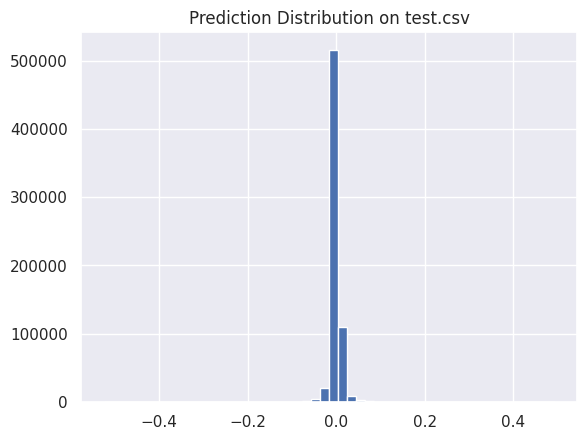

In [ ]:
plt.hist(pred_train.flatten(), bins=50)
plt.title("Prediction Distribution on train.csv")
plt.show()

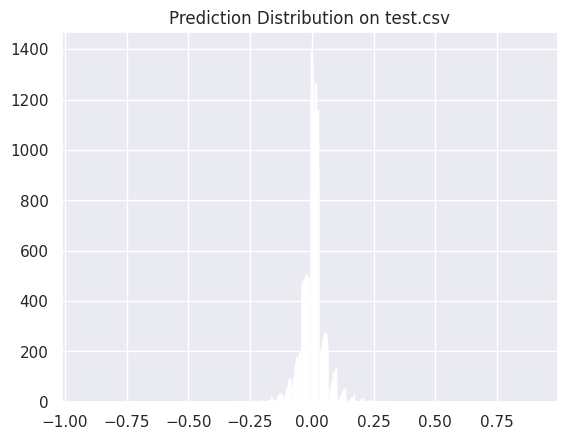

In [ ]:
plt.hist(y_train, bins=50)
plt.title("Prediction Distribution on original labels")
plt.show()

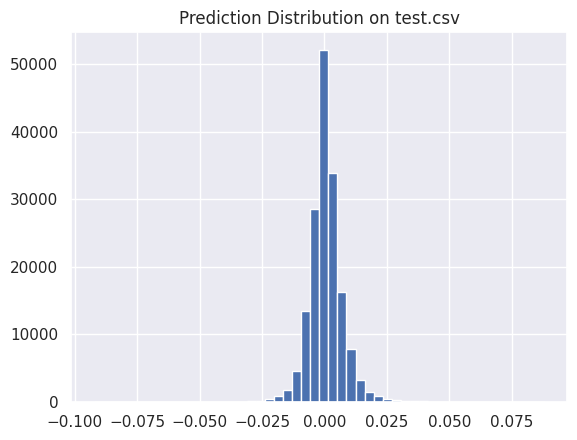

In [ ]:
plt.hist(pred_test.flatten(), bins=50)
plt.title("Prediction Distribution on test.csv")
plt.show()


# Training CatBoost Regressor

In [ ]:
if TRAIN_CatBoost:

    # Initialize model 
    print("Training CatBoost model")
    start_time = time.time()
    
    model_CatBoost.fit(X_train, y_train)
    end_time = time.time()
    print("Training Completed")
    print(f"Total time taken = {end_time - start_time} seconds")

    # Save model
    joblib.dump(model_CatBoost, f"{MODEL_OUTPUT_DIR}/CatBoost.pkl")

    # Train Sharpe Score
    pred_train = model_CatBoost.predict(X_train)
    train_sharpe = rankcorr_sharpe(
        pd.DataFrame(pred_train, index=y_train.index, columns=TARGETS),
        pd.DataFrame(y_train,   index=y_train.index, columns=TARGETS)
    )
    
    print(f"\nTRAIN RankCorr-Sharpe: {train_sharpe:.4f}")
    
    # Test Sharpe Score
    pred_test = model_CatBoost.predict(X_test)
    test_sharpe = rankcorr_sharpe(
        pd.DataFrame(pred_test, index=y_test.index, columns=TARGETS),
        pd.DataFrame(y_test,    index=y_test.index, columns=TARGETS)
    )
    
    print(f"TEST  RankCorr-Sharpe: {test_sharpe:.4f}")

# Multi-Output LightGBM Regressor Training

In [ ]:
if TRAIN_LightGBM:
    
    # Initialize model 
    print("Training LightGBM model")
    start_time = time.time()
    
    model_LGBM.fit(X_train, y_train)
    end_time = time.time()
    print("Training Completed")
    print(f"Total time taken = {end_time - start_time} seconds")

    # Save model
    joblib.dump(model_LGBM, f"{MODEL_OUTPUT_DIR}/LightGBM.pkl")

    # Train Sharpe Score
    pred_train = model_LGBM.predict(X_train)
    train_sharpe = rankcorr_sharpe(
        pd.DataFrame(pred_train, index=y_train.index, columns=TARGETS),
        pd.DataFrame(y_train,   index=y_train.index, columns=TARGETS)
    )
    
    print(f"\nTRAIN RankCorr-Sharpe: {train_sharpe:.4f}")
    
    # Test Sharpe Score
    pred_test = model_LGBM.predict(X_test)
    test_sharpe = rankcorr_sharpe(
        pd.DataFrame(pred_test, index=y_test.index, columns=TARGETS),
        pd.DataFrame(y_test,    index=y_test.index, columns=TARGETS)
    )
    
    print(f"TEST  RankCorr-Sharpe: {test_sharpe:.4f}")
    

# Training 424 Separate Single-Output LGBMRegressor for Each Target

In [ ]:
models         = {}  
MODEL_FEATURES = {}  
MODELS_LOADED  = False

def _meta_path_for(tgt: str) -> str:
    return os.path.join(MODEL_OUTPUT_DIR, f"{tgt}_feat.pkl")

def _load_model_and_meta(tgt: str, input_dir: str):
    mpath = os.path.join(input_dir, f"{tgt}_model.pkl")
    fpath = os.path.join(input_dir, f"{tgt}_feat.pkl")
    model = joblib.load(mpath) if os.path.exists(mpath) else None
    feats = None
    if os.path.exists(fpath):
        try:
            feats = joblib.load(fpath)
        except Exception:
            feats = None
    return model, feats

def _fallback_feature_order_for_model(model) -> list:
    n = getattr(model, "n_features_", None)
    if not isinstance(n, (int, np.integer)) or n < 1:
        return (FEATURE_BASE + ['target_name_encoded'])
    take = max(0, n - 1)
    return (FEATURE_BASE[:take] + ['target_name_encoded'])

def _lazy_load_models():
    global MODELS_LOADED, models, MODEL_FEATURES
    if MODELS_LOADED:
        return
    loaded = 0
    for tgt in TARGETS:
        model, feats = _load_model_and_meta(tgt, MODEL_INPUT_DIR)
        models[tgt] = model
        if (model is not None) and (feats is None):
            feats = _fallback_feature_order_for_model(model)
        MODEL_FEATURES[tgt] = feats if feats is not None else (FEATURE_BASE + ['target_name_encoded'])
        if models[tgt] is not None:
            loaded += 1
    MODELS_LOADED = True
    print(f"[Info] Lazy-loaded models: {loaded} / {len(TARGETS)}")

In [ ]:
if TRAIN_LGBM_Multiple:
    print("Training Multiple Single-Output LGBMRegressor")
    start_time = time.time()
    X_all_df = create_features(train).to_pandas()
    X_all    = X_all_df[FEATURE_BASE]
    y_all    = train_labels.to_pandas()[TARGETS]

    for idx, tgt in enumerate(TARGETS):
        print(f"Training {tgt} …")
        y = y_all[tgt]
        mask = ~y.isna()
        X_tr_base = X_all.loc[mask].copy()
        y_tr      = y.loc[mask]
        if len(y_tr) == 0:
            print(f"  Skip {tgt}: no non-null labels.")
            models[tgt] = None
            MODEL_FEATURES[tgt] = FEATURE_BASE + ['target_name_encoded']
            joblib.dump(MODEL_FEATURES[tgt], _meta_path_for(tgt))
            continue

        X_tr = X_tr_base.copy()
        X_tr['target_name_encoded'] = idx
        X_tr = preprocess_columns(X_tr)

        feat_order = FEATURE_BASE + ['target_name_encoded']
        X_tr = X_tr.reindex(columns=feat_order, fill_value=0.0)

        m = LGBMRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        )
        m.fit(X_tr, y_tr)

        models[tgt] = m
        MODEL_FEATURES[tgt] = feat_order
        joblib.dump(m, os.path.join(MODEL_OUTPUT_DIR, f"{tgt}_model.pkl"))
        joblib.dump(feat_order, _meta_path_for(tgt))
    end_time = time.time();
    print("Training Completed")
    print(f"Total Time Taken: {end_time - start_time}")
    print(f"Saved models & metadata to: {MODEL_OUTPUT_DIR}")

Training Multiple Single-Output LGBMRegressor
Training target_0 …
Training target_1 …
Training target_2 …
Training target_3 …
Training target_4 …
Training target_5 …
Training target_6 …
Training target_7 …
Training target_8 …
Training target_9 …
Training target_10 …
Training target_11 …
Training target_12 …
Training target_13 …
Training target_14 …
Training target_15 …
Training target_16 …
Training target_17 …
Training target_18 …
Training target_19 …
Training target_20 …
Training target_21 …
Training target_22 …
Training target_23 …
Training target_24 …
Training target_25 …
Training target_26 …
Training target_27 …
Training target_28 …
Training target_29 …
Training target_30 …
Training target_31 …
Training target_32 …
Training target_33 …
Training target_34 …
Training target_35 …
Training target_36 …
Training target_37 …
Training target_38 …
Training target_39 …
Training target_40 …
Training target_41 …
Training target_42 …
Training target_43 …
Training target_44 …
Training target_45 

In [ ]:
if (DO_CV):    
    print(f"\nRunning TimeSeriesSplit CV with {CV_SPLITS} folds …")
    
    tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
    oof_preds = np.zeros_like(y_train.values, dtype=float)
    
    fold_sharpes = []
    
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
        print(f"\n  Fold {fold+1}/{CV_SPLITS}")
    
        # Split features
        X_tr = X_train[tr_idx]
        y_tr = y_train.iloc[tr_idx]
    
        X_va = X_train[va_idx]
        y_va = y_train.iloc[va_idx]
    
        # New multi-output model for each fold
        model_cv = LGBMRegressor(
            n_estimators=400,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=128,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED,
            verbose=-1
        )
    
        # Train
        model_cv.fit(X_tr, y_tr)
    
        # Predict for the full validation block
        preds_va = model_cv.predict(X_va)
    
        # Store OOF predictions
        oof_preds[va_idx] = preds_va
    
        # Compute fold sharpe
        fold_score = rankcorr_sharpe(
            pd.DataFrame(preds_va, columns=TARGETS),
            y_va.reset_index(drop=True)
        )
        fold_sharpes.append(fold_score)
        print(f"    Fold Sharpe = {fold_score:.5f}")
    
    # After all folds → global OOF Sharpe
    oof_df = pd.DataFrame(oof_preds, columns=TARGETS)
    oof_score = rankcorr_sharpe(oof_df, y_train.reset_index(drop=True))
    
    print("\nCV SUMMARY")
    print(f"OOF RankCorr-Sharpe = {oof_score:.5f}")
    print(f"Mean(Fold Sharpe)   = {np.mean(fold_sharpes):.5f}")


# Predict Function for Kaggle Server

In [ ]:
def predict_multiLGBM(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pd.DataFrame:
    """
    Using Multi Single-Output LGBMRegressor models for prediction.
    424 separate models are loaded lazily on the first call.
    Each model predicts its corresponding target using the appropriate features.
    """
    _lazy_load_models()

    df_feat = create_features(test)
    X_base  = df_feat.to_pandas()

    base_selected = X_base.reindex(columns=FEATURE_BASE, fill_value=0.0)

    n_rows = len(base_selected)
    out = np.zeros((n_rows, len(TARGETS)), dtype=np.float64)

    for idx, tgt in enumerate(TARGETS):
        model = models.get(tgt)
        if model is None:
            out[:, idx] = 0.0
            continue
    
        feat_order = MODEL_FEATURES.get(tgt)
        if feat_order is None:
            feat_order = _fallback_feature_order_for_model(model)

        X_tmp = base_selected.copy()
        X_tmp['target_name_encoded'] = idx

        X_tmp = preprocess_columns(X_tmp)
        X_tmp = X_tmp.reindex(columns=feat_order, fill_value=0.0)

        pred = model.predict(X_tmp, validate_features=False)
        pred = np.asarray(pred, dtype=np.float64).reshape(-1)
        if pred.shape[0] != n_rows:
            if pred.shape[0] > n_rows:
                pred = pred[:n_rows]
            else:
                pred = np.pad(pred, (0, n_rows - pred.shape[0]), constant_values=0.0)
        out[:, idx] = pred

    out = np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

    predictions = pd.DataFrame(out, columns=TARGETS)
    assert predictions.shape[1] == 424, f"Expected 424 columns, got {predictions.shape[1]}"
    assert list(predictions.columns) == TARGETS, "Column order/name mismatch"
    assert np.isfinite(predictions.to_numpy()).all(), "Non-finite values in predictions"
    return predictions


In [ ]:
def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pd.DataFrame:
    
    X_test = (
        preprocess_columns(
            test
            .select(pl.col(FEATURE_COLUMNS))
            .to_pandas()
            .fillna(-1)
        ).reindex(
            columns=FEATURE_COLUMNS,
            fill_value=0.0
        )
    ).copy()
    
    if (TRAIN_RandomForest):
        pred = model_RandomForest.predict(X_test)
    elif (TRAIN_LightGBM):
        pred = model_LGBM.predict(X_test)
    elif (TRAIN_CatBoost):
        pred = model_CatBoost.predict(X_test)
    elif (TRAIN_LGBM_Multiple):
        pred = predict_multiLGBM(
            test,
            label_lags_1_batch,
            label_lags_2_batch,
            label_lags_3_batch,
            label_lags_4_batch
        ).to_numpy()
        
    predictions = pd.DataFrame(pred, columns=TARGETS)
    return predictions

In [25]:
if IS_KAGGLE:
    inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        inference_server.run_local_gateway((DATA_PATH,))
else:
    mock = pl.DataFrame()
    submission = predict(test, mock, mock, mock, mock)
    submission = submission[TARGETS]
    submission.to_csv("submission_local.csv", index=False)
    print("Local submission saved → submission_local.csv")

# Project Summary: Approach & Solution Workflow

### Data Loading
- Implemented an automatic loader that detects whether the notebook is running on Kaggle or locally and loads the dataset accordingly.

### Exploratory Data Analysis
- Performed targeted EDA including exchange-group distributions, pair-level target analysis, time-series inspection of selected assets, and spread visualizations across multiple target pairs.

### Competition Metric
- Implemented the custom RankCorr-Sharpe evaluation function as required by the competition.

### Dataset Preparation
- Applied preprocessing, feature engineering (lags, rolling statistics, etc.), and created train–test splits for modeling.

### Model Development
- Trained four models:

    - RandomForest Regressor

    - CatBoost Regressor

    - Single multi-output LightGBM

    - Multiple single-output LightGBM models

### Model Training & Evaluation
- The RandomForest baseline achieved:
    - TRAIN RankCorr-Sharpe: 6.8863
    - TEST RankCorr-Sharpe: 1.9417
- Additional cross-validation was performed using the single-output LightGBM models.

### Prediction Pipeline
- Implemented the final predict() function for seamless Kaggle inference.

### Conclusion
- Although the model performance was modest, the project provided strong learning on financial time-series modeling, custom metrics, and multi-output ML pipelines. Future improvements will continue refining features and model architectures.